In [11]:
%matplotlib inline
!pip install ultralytics==8.3.16 tqdm

import os, json, shutil, random
from tqdm import tqdm

[notice] A new release of pip is available: 25.1 -> 25.3

[notice] To update, run: python.exe -m pip install --upgrade pip

In [2]:
IMG_DIR = "CatFLW/images"
LBL_DIR = "CatFLW/labels"
YOLO_DIR = "yolo_data"
os.makedirs(YOLO_DIR, exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/val", exist_ok=True)

Load data and convert into YOLO format

In [3]:
def convert_to_yolo(bbox, img_w, img_h):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return x_center, y_center, w, h

In [4]:
all_files = [f for f in os.listdir(LBL_DIR) if f.endswith(".json")]
random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files, val_files = all_files[:split_idx], all_files[split_idx:]

for split, files in [("train", train_files), ("val", val_files)]:
    for label_file in tqdm(files, desc=f"Preparing {split}"):
        img_file = label_file.replace(".json", ".png")
        img_path = os.path.join(IMG_DIR, img_file)
        if not os.path.exists(img_path):
            continue

        # Read image size
        import cv2
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape

        # Read JSON
        with open(os.path.join(LBL_DIR, label_file)) as f:
            data = json.load(f)
        bbox = data["bounding_boxes"]

        # Convert bbox to YOLO format
        x, y, bw, bh = convert_to_yolo(bbox, w, h)
        yolo_line = f"0 {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n"

        # Save label
        txt_path = os.path.join(YOLO_DIR, f"labels/{split}", img_file.replace(".png", ".txt"))
        with open(txt_path, "w") as f:
            f.write(yolo_line)

        # Copy image
        shutil.copy(img_path, os.path.join(YOLO_DIR, f"images/{split}", img_file))

print("✅ Dataset converted to YOLO format")

Preparing val: 100%|█████████████████████████████████████████████████████████████████| 416/416 [00:15<00:00, 27.25it/s]

✅ Dataset converted to YOLO format


In [5]:
yaml_content = f"""
path: {os.path.abspath(YOLO_DIR)}
train: images/train
val: images/val

nc: 1
names: ['cat_face']
"""
with open(f"{YOLO_DIR}/catface.yaml", "w") as f:
    f.write(yaml_content)

print("✅ YOLO dataset config created")


✅ YOLO dataset config created


Load pretrained YOLO and train

In [7]:
import torch
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Nano model pretrained on COCO

device = 0 if torch.cuda.is_available() else "cpu"

model.train(
    data=f"{YOLO_DIR}/catface.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device=device,
    project="runs_catface",
    name="yolov8n_catface",
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.3.222 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.16  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_data/catface.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs_catface, name=yolov8n_catface, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

100%|███████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 1.49MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anvu2211 (anvu2211-university-of-technology-sydney) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:05<00:00, 1.06MB/s]


AMP: checks passed 


train: Scanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train...:   0%|          | 0Scanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 25 images, 0 backgrScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 56 images, 0 backgrScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 83 images, 0 backgrScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 118 images, 0 backgScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 149 images, 0 backgScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 179 images, 0 backgScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 214 images, 0 backgScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train... 251 

train: New cache created: C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\train.cache


val: Scanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val...:   0%|          | 0/416Scanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 24 images, 0 backgroundScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 56 images, 0 backgroundScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 88 images, 0 backgroundScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 117 images, 0 backgrounScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 145 images, 0 backgrounScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 175 images, 0 backgrounScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val... 203 images, 0 backgrounScanning C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels

val: New cache created: C:\Data\Projects\Image Processing and Pattern Recognition\yolo_data\labels\val.cache
Plotting labels to runs_catface\yolov8n_catface\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs_catface\yolov8n_catface
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      1.145      1.908      1.455         38        640: 100%|██████████| 104/104 [00:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03


                   all        416        416      0.869       0.73      0.857      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.19G      1.055      1.149      1.345         33        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.897      0.881      0.942      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.2G      1.051     0.9621       1.33         38        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.864      0.825      0.899      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.2G      1.015      0.861      1.296         29        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.945      0.897      0.967      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.19G     0.9673     0.7562      1.266         32        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.95      0.964      0.979      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.19G     0.9665     0.7372      1.268         30        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.939       0.94      0.983      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.19G     0.9524     0.6873      1.247         35        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.966       0.97      0.984      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.19G     0.9173     0.6472      1.232         38        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.964      0.978      0.989      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.19G     0.8946     0.6299      1.229         33        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.98      0.966      0.987      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.19G     0.9014     0.6207       1.22         28        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.974      0.964      0.986      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.19G     0.8778     0.5915      1.202         29        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.98      0.974      0.988      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.19G     0.8449     0.5729      1.187         33        640: 100%|██████████| 104/104 [00:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.981       0.99      0.992      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.19G     0.8444     0.5654      1.182         38        640: 100%|██████████| 104/104 [00:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.985       0.99      0.991      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.19G     0.8313     0.5491      1.176         35        640: 100%|██████████| 104/104 [00:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.992      0.986      0.994      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.19G     0.8252     0.5349      1.174         35        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.985      0.988      0.993      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.19G     0.8092     0.5287      1.168         36        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.981       0.99      0.992      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.19G     0.8157     0.5205      1.165         34        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.988      0.992      0.995      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.19G     0.7912     0.5089      1.144         30        640: 100%|██████████| 104/104 [00:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.989      0.998      0.993      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.19G      0.785     0.4843      1.136         32        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.99      0.986      0.994      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.19G     0.7787     0.4947      1.137         38        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.98      0.988      0.993      0.798
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.19G     0.6935     0.3541      1.111         15        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.99      0.988      0.995      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.19G     0.6726      0.328      1.092         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.99       0.99      0.993      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.19G     0.6636     0.3241      1.091         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.984      0.993      0.994       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.19G      0.651     0.3128      1.077         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.99      0.998      0.994      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.19G     0.6403     0.3052      1.076         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.983      0.988      0.994      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.19G     0.6313     0.2998      1.067         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416       0.99      0.987      0.993      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.19G     0.6119     0.2877       1.05         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.993      0.999      0.993       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.19G     0.6017     0.2781      1.051         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.986      0.997      0.993      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.19G     0.5865      0.266       1.03         15        640: 100%|██████████| 104/104 [00:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.985      0.995      0.994      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.19G     0.5844     0.2636      1.034         15        640: 100%|██████████| 104/104 [00:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.993      0.988      0.994      0.833

30 epochs completed in 0.151 hours.
Optimizer stripped from runs_catface\yolov8n_catface\weights\last.pt, 5.6MB
Optimizer stripped from runs_catface\yolov8n_catface\weights\best.pt, 5.6MB

Validating runs_catface\yolov8n_catface\weights\best.pt...
Ultralytics 8.3.16  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02


                   all        416        416      0.985      0.995      0.994      0.834
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs_catface\yolov8n_catface


lr/pg0,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▅▃▇▇▇▇███████████████████████
metrics/mAP50-95(B),▁▄▃▅▆▅▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
metrics/precision(B),▁▃▁▅▆▅▇▆▇▇▇▇███▇███▇████▇█████
metrics/recall(B),▁▅▃▅▇▆▇▇▇▇▇███████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000276194B7290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Test on a random image

Testing on: CatFLW/images\CAT_01_00000167_028.png

image 1/1 C:\Data\Projects\Image Processing and Pattern Recognition\CatFLW\images\CAT_01_00000167_028.png: 544x640 1 cat_face, 146.2ms
Speed: 5.3ms preprocess, 146.2ms inference, 4.3ms postprocess per image at shape (1, 3, 544, 640)


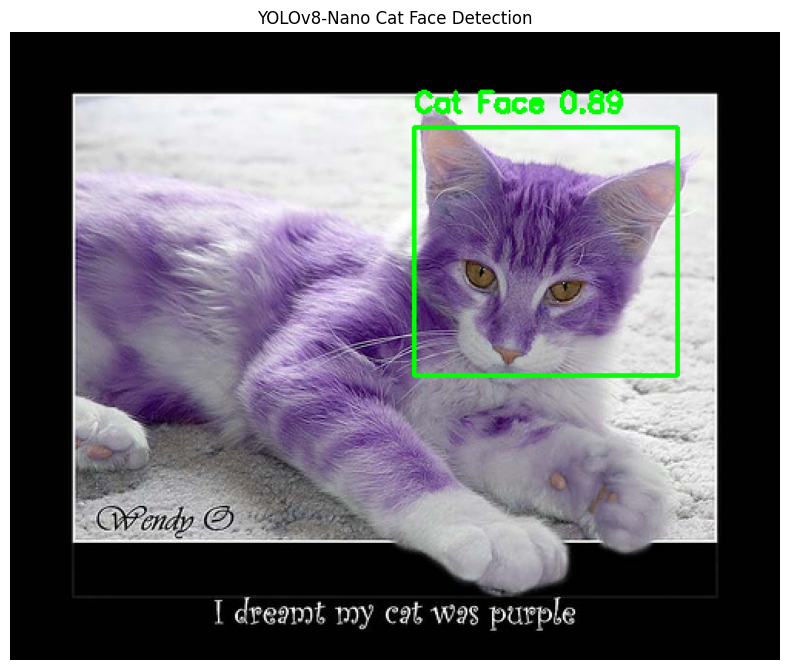

In [36]:
import cv2
import matplotlib.pyplot as plt

# Pick an image to test
test_img_path = random.choice(os.listdir(IMG_DIR))
test_img_path = os.path.join(IMG_DIR, test_img_path)
print("Testing on:", test_img_path)

# Run YOLO inference
results = model.predict(source=test_img_path, conf=0.25, save=False)[0]

# Load image
img = cv2.imread(test_img_path)

# # Draw bounding boxes
# for box in results.boxes:
#     x1, y1, x2, y2 = map(int, box.xyxy[0])
#     conf = float(box.conf[0])
#     label = f"Cat Face {conf:.2f}"
#     cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

shrink_factor = 0.85
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = float(box.conf[0])

    # shrink the box around its center
    w = x2 - x1
    h = y2 - y1
    cx = x1 + w / 2
    cy = y1 + h / 2
    new_w = w * shrink_factor
    new_h = h * shrink_factor
    x1 = int(cx - new_w / 2)
    x2 = int(cx + new_w / 2)
    y1 = int(cy - new_h / 2)
    y2 = int(cy + new_h / 2)

    # draw new (tighter) box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    label = f"Cat Face {conf:.2f}"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show the result properly
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8-Nano Cat Face Detection")
plt.axis("off")

# Force the plot to display
plt.tight_layout()
plt.show(block=True)